In [1]:
import pandas as pd
import numpy as np
import glob, sys, os
sys.path.append('..')

In [2]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk', font_scale=0.8)

In [3]:
## Run the helper fucntions form the local CDK2 directory
%run ./helper_1_load_data.ipynb

In [4]:
# Helper fucntion to train and test
%run ./helper_functions_S6.ipynb

# Pipeline

###  Linear Support Vector Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>

The following **linear SVM** is trained using **DEKOIS** (*Dk_sc* and *Dk_lef*, respectively) and testing with **DUD**.  
All conformations (136 features) are used.

<ol class="list-group list-group-flush">

  <li class="list-group-item"><span style='background-color: #FDC677; padding: 5px;'>1)</span>
     <span style='font-weight: bold;'>Model:</span> <i>Linear SVC</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FEBB73; padding: 5px;'>2)</span>
     <span style='font-weight: bold;'>Training:</span> <i>DEKOIS</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FFA66C; padding: 5px;'>3)</span>
     <span style='font-weight: bold;'>Testing:</span> <i>DUD</i>.
    </li>
  <li class="list-group-item"><span style='background-color: #FE8460; padding: 5px;'>4)</span>
     <span style='font-weight: bold;'>Num. Features:</span> <i>All: 136 conformations</i>.
    </li>
</ol>

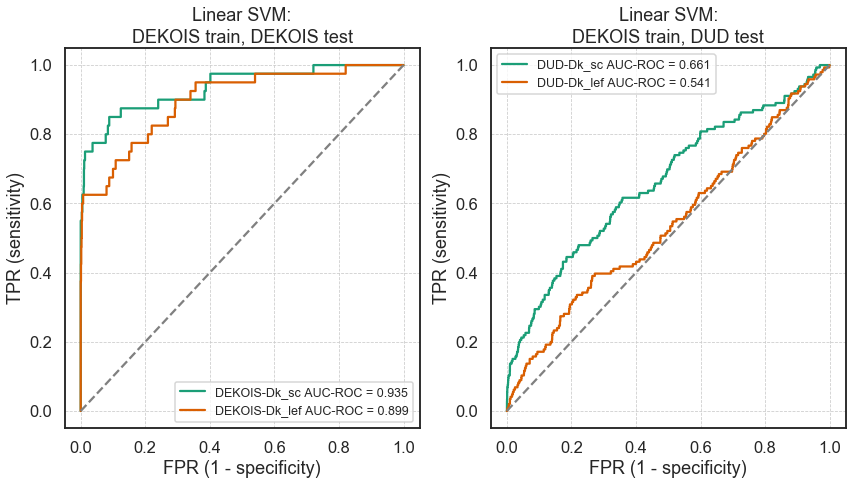

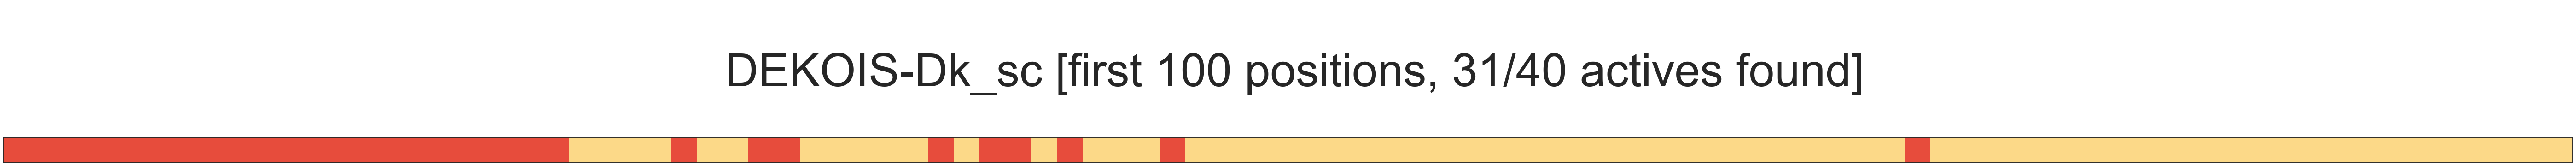

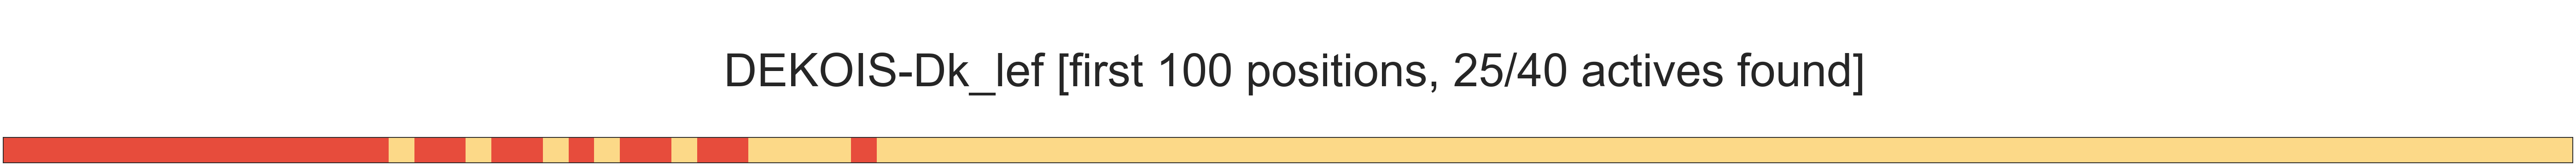

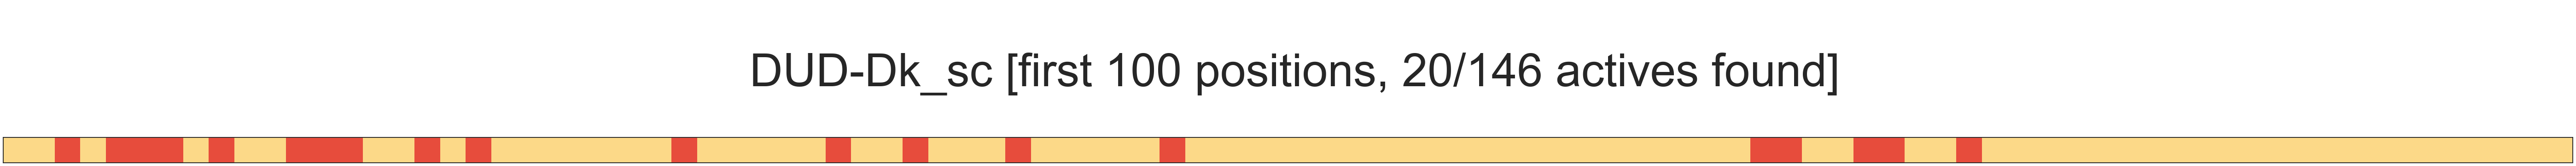

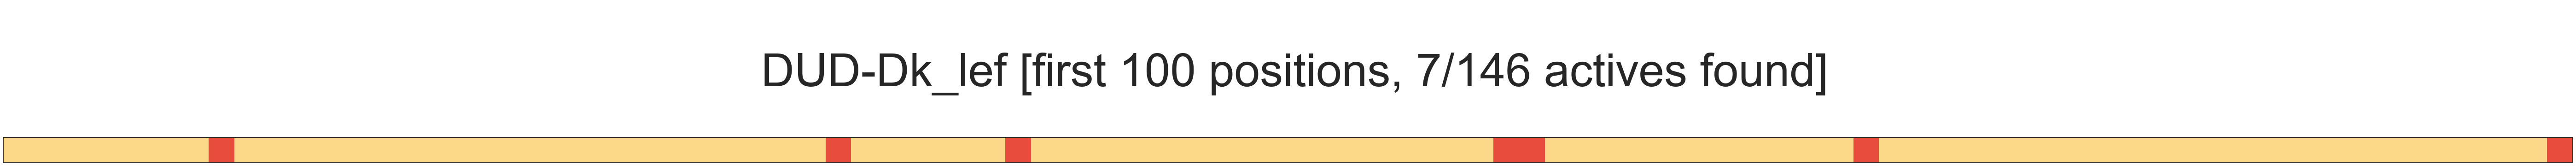

{'estimator__C': 0.001}
CPU times: user 4.5 s, sys: 589 ms, total: 5.09 s
Wall time: 18.1 s


In [5]:
%%time
# Params to eval through grid search
svc_hyparams = {'C': np.geomspace(0.00001, 0.1, 5)}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'DEKOIS'
# The name of the datasets which will be used for  testing
test_keys = ['DEKOIS', 'DUD']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores,
                            scores_dic = scores_dic,
                            estimator= SVC, estimator_hyparams = svc_hyparams,
                            # kwargs exclusive for SVC
                            kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

# Best estimator for DkSc
print(svm_lineal['Dk_sc'].best_params_)

###  Radial Basis Function Support Vector Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


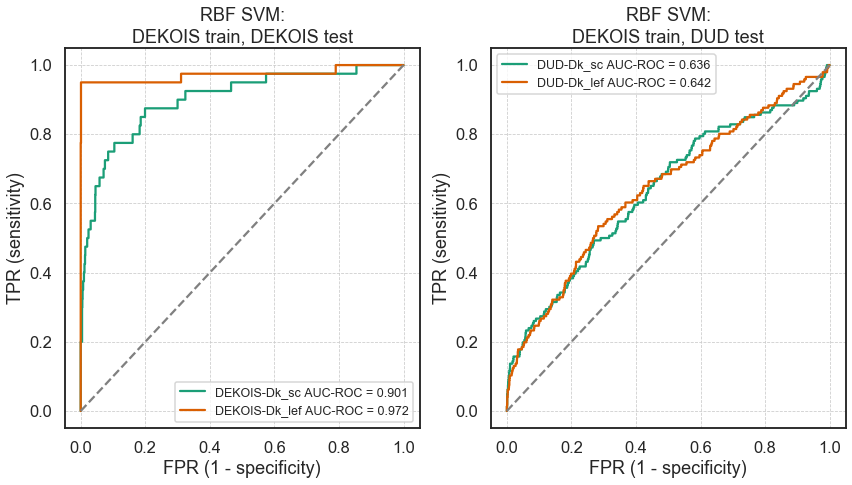

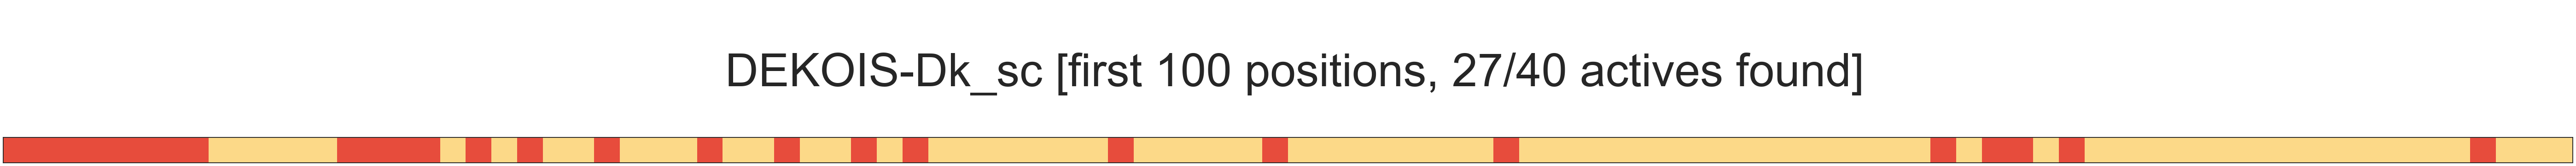

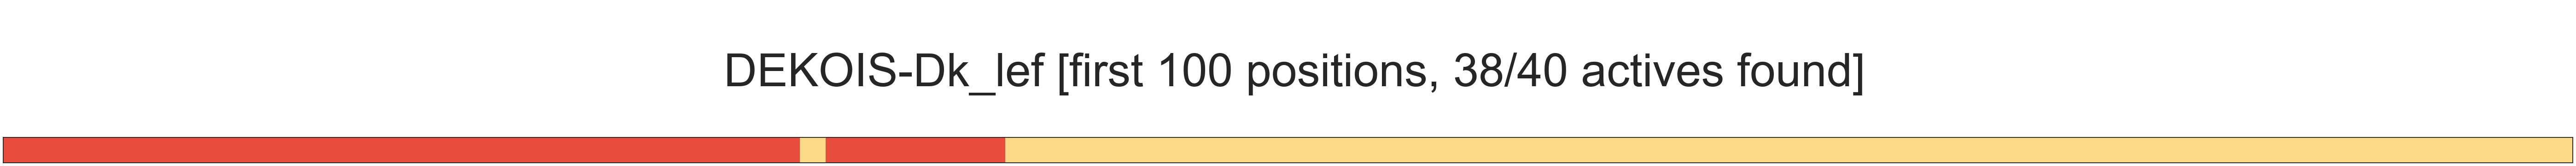

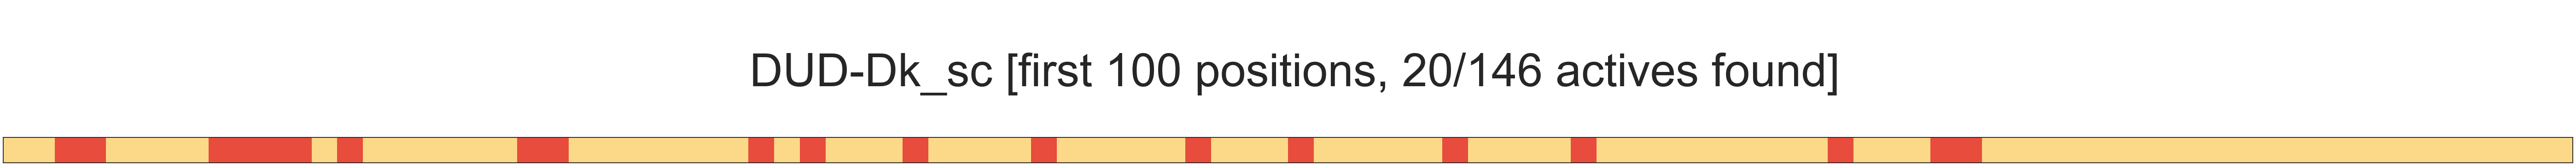

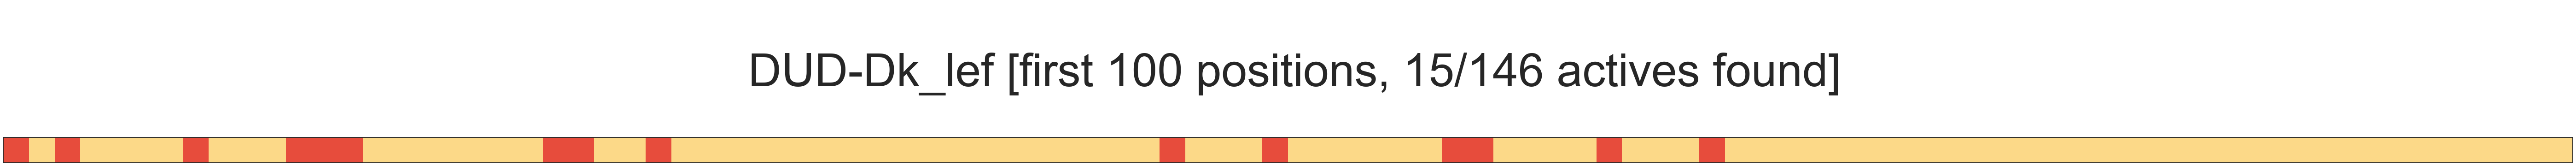

{'estimator__C': 0.0001, 'estimator__gamma': 0.0001}
CPU times: user 5.2 s, sys: 348 ms, total: 5.55 s
Wall time: 10.7 s


In [6]:
%%time
svc_params = {'gamma': [0.0001, 0.001, 0.01],'C': np.geomspace(0.0001, 1, 5)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        scores_dic = scores_dic,
                        estimator= SVC, estimator_hyparams = svc_params,
                        kernel = 'rbf', probability = True)
# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)
print(svm_rbf['Dk_sc'].best_params_)

### Logistic Regression
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [7]:
from sklearn.linear_model import LogisticRegression

Model for Dk_sc:
	Best parameters: {'estimator__C': 0.001, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
	Train set accuracy: 0.893
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
	Train set accuracy: 0.739


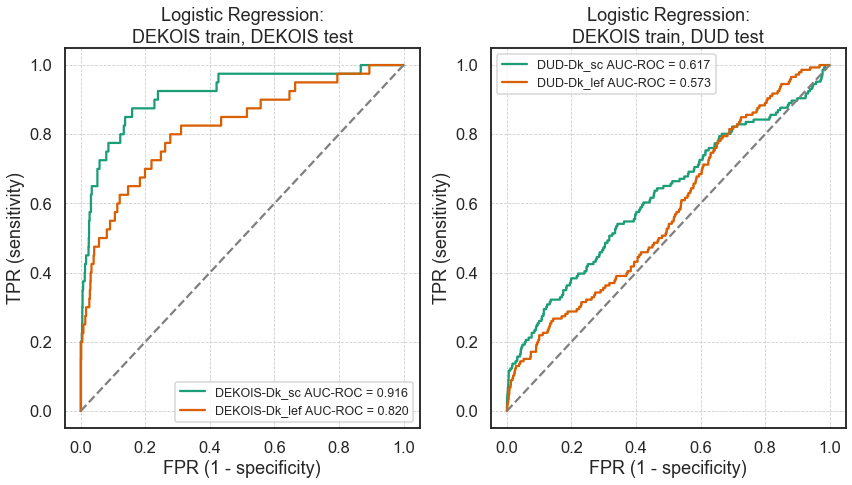

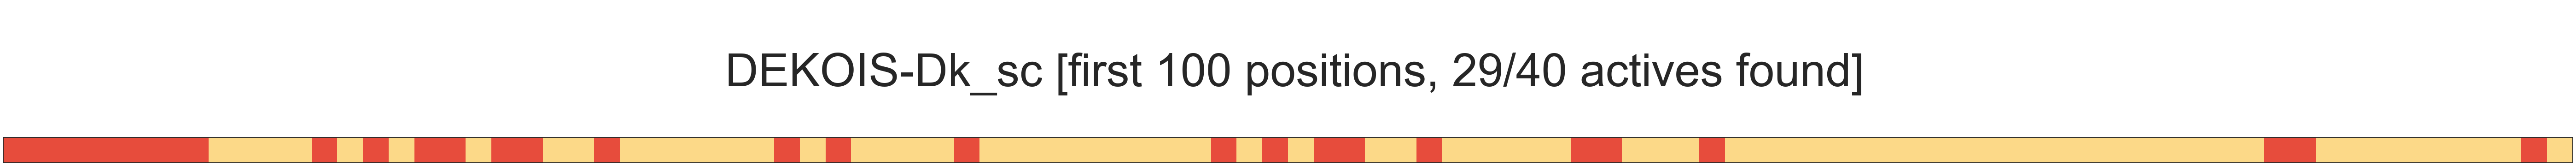

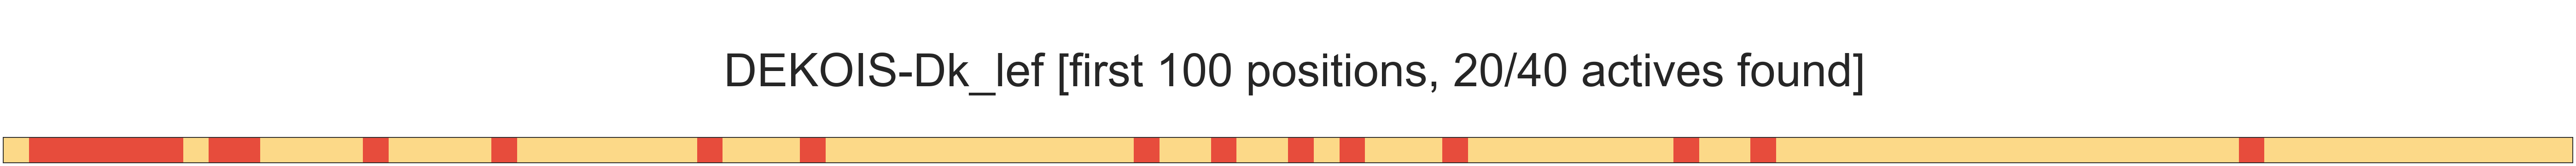

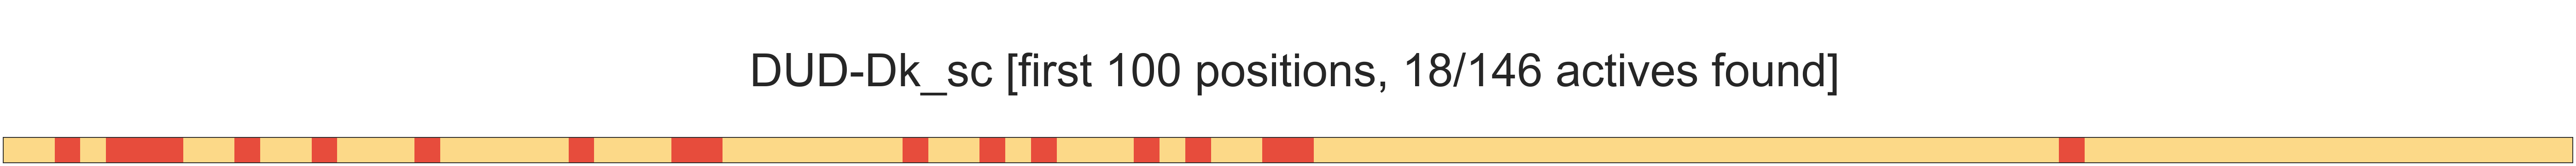

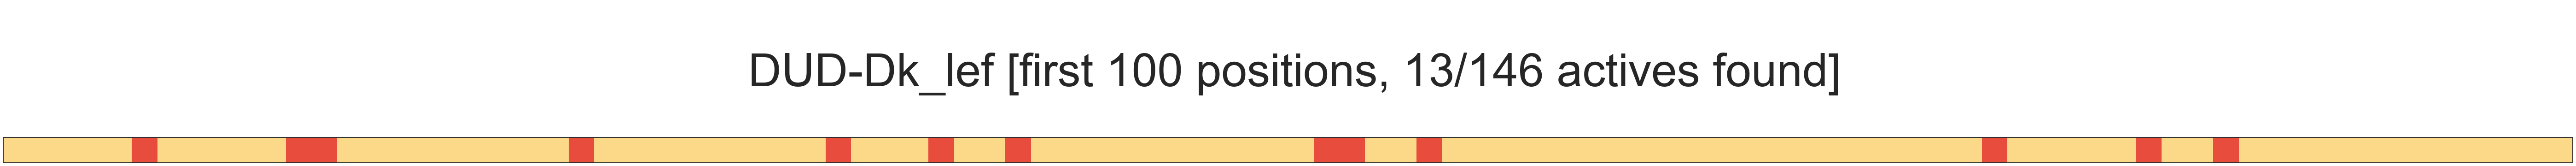

CPU times: user 4.15 s, sys: 731 ms, total: 4.88 s
Wall time: 4.99 s


In [8]:
%%time
lg_params = {'C': [0.0001, 0.001, 0.01, 0.1], 
             'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
LG = LogisticRegression
lg_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                        estimator= LG, estimator_hyparams = lg_params)
# Parameters used
for name, model in lg_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
lg_clf_pred = eval_wrapper(trained_model = lg_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = lg_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

###  Random Forest Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [9]:
from sklearn.ensemble import RandomForestClassifier

Model for Dk_sc:
	Best parameters: {'estimator__max_depth': 10, 'estimator__max_features': 5, 'estimator__n_estimators': 30}
	Train set accuracy: 0.888
Model for Dk_lef:
	Best parameters: {'estimator__max_depth': 10, 'estimator__max_features': 5, 'estimator__n_estimators': 20}
	Train set accuracy: 0.689


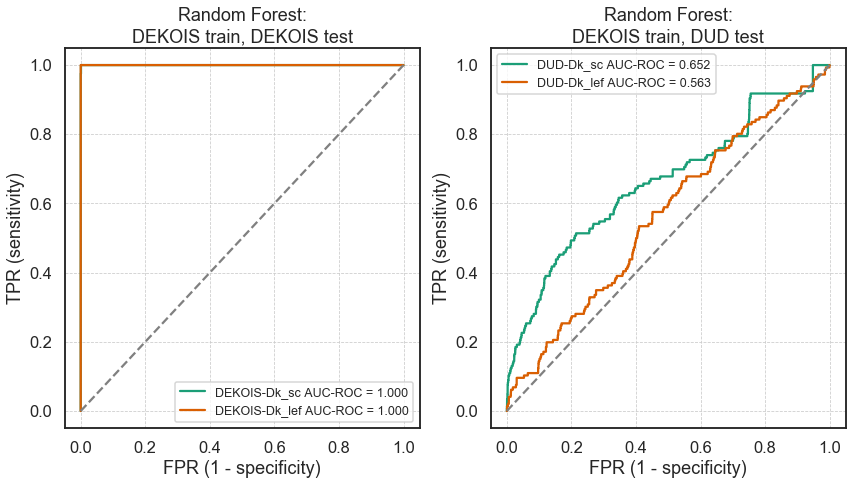

CPU times: user 3.09 s, sys: 736 ms, total: 3.83 s
Wall time: 21.2 s


In [10]:
%%time
rf_params = {'n_estimators': [5, 10, 20, 30],
             'max_features': [5, 10, 20, 30],
             'max_depth': [10, 20]}

list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
RF = RandomForestClassifier
rf_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, scores_dic = scores_dic,
                       estimator_hyparams = rf_params, standarize = False, estimator= RF,
                       # Hyperparameters
                       n_jobs = -1)

# Parameters used
for name, model in rf_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
rf_clf_pred = eval_wrapper(trained_model = rf_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Random Forest', predictions = rf_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


###  K Nearest Neighbors Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [11]:
from sklearn.neighbors import KNeighborsClassifier

Model for Dk_sc:
	Best parameters: {'estimator__n_neighbors': 55, 'estimator__p': 1}
	Train set accuracy: 0.864
Model for Dk_lef:
	Best parameters: {'estimator__n_neighbors': 25, 'estimator__p': 1}
	Train set accuracy: 0.729


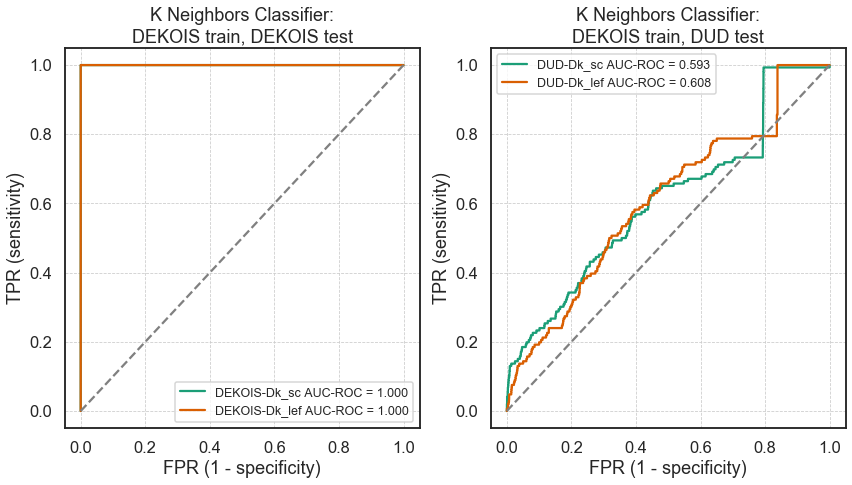

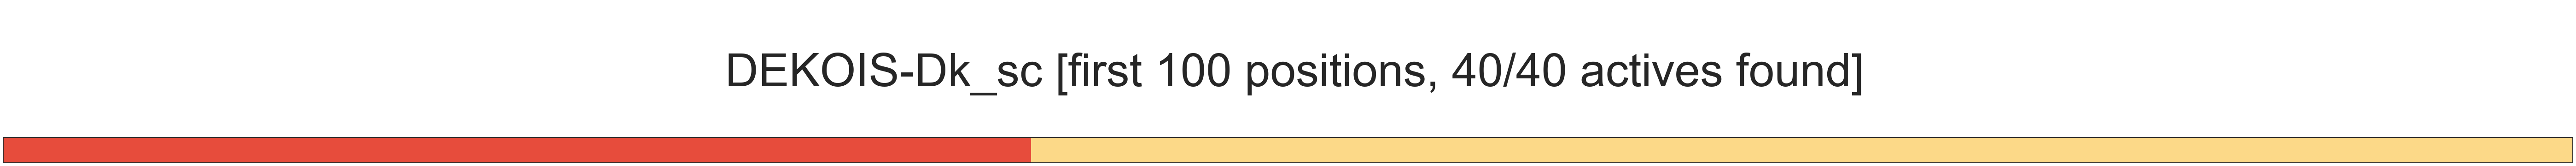

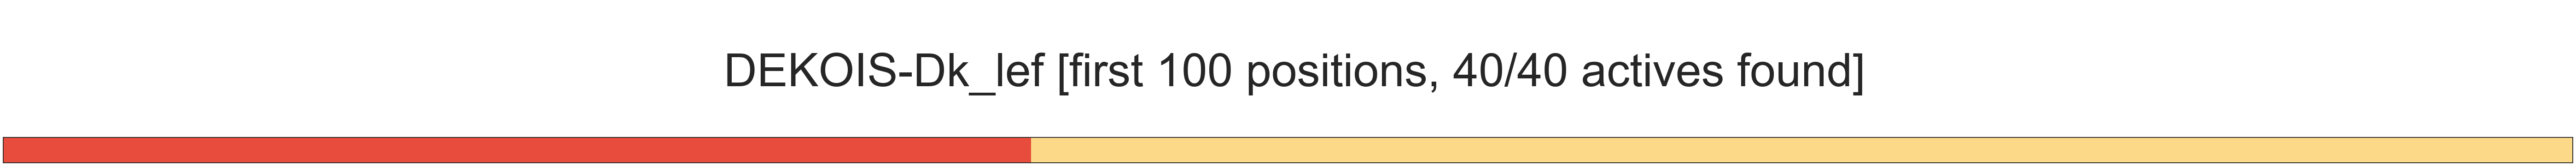

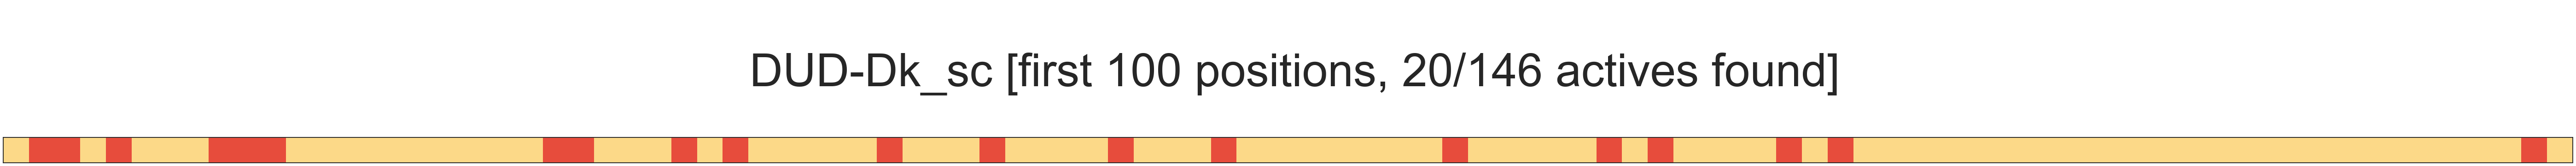

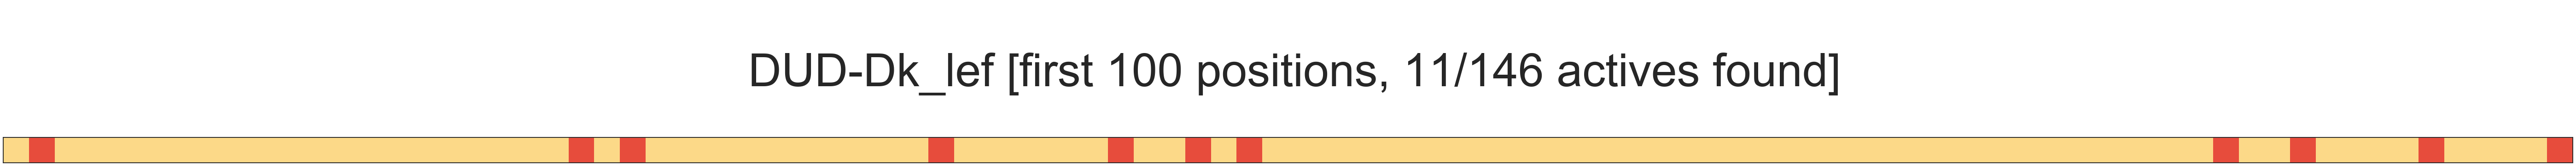

CPU times: user 13.8 s, sys: 251 ms, total: 14 s
Wall time: 8.72 s


In [14]:
%%time
knc_params = {'n_neighbors': [15, 25, 55, 75], 
             'p': [1, 2] # Distance criterion 1: manhattan and 2: euclidean
             }
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
KNC = KNeighborsClassifier
knc_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                       estimator= KNC, estimator_hyparams = knc_params,
                        # Hyperparameters
                       algorithm = 'kd_tree', n_jobs = 4, weights = 'distance')
# Parameters used
for name, model in knc_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
knc_clf_pred = eval_wrapper(trained_model = knc_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'K Neighbors Classifier', predictions = knc_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)